In [1]:
# Imports
import os
import numpy as np
import pandas as pd
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.sql import functions as f
from pyspark.sql.functions import udf, StringType, col, when, max, min, rand, hour, minute, expr
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, StringIndexer
from functools import reduce

In [ ]:
# Building session now
spark = SparkSession.builder.appName('deep_learning_with_spark').getOrCreate()


In [3]:
# Load data from csv
df1 = spark.read.csv('/mnt/bdpa23-group14-pvc/accidents_2005_to_2007.csv', header=True, inferSchema=True)
df2 = spark.read.csv('/mnt/bdpa23-group14-pvc/accidents_2009_to_2011.csv', header=True, inferSchema=True)
df3 = spark.read.csv('/mnt/bdpa23-group14-pvc/accidents_2012_to_2014.csv', header=True, inferSchema=True)
# Combine the DataFrames into a single DataFrame
data = df1.union(df2).union(df3)

In [4]:
# Drop 2 columns containing lots of null values and then drop remaining rows
# that contain null values. Most rows survive
print(data.count())
data = data.withColumn('Accident_Severity', when(data.Accident_Severity == 1, 0).otherwise(data.Accident_Severity))
data = data.withColumn('Accident_Severity', when(data.Accident_Severity == 2, 1).otherwise(data.Accident_Severity))
data = data.withColumn('Accident_Severity', when(data.Accident_Severity == 3, 2).otherwise(data.Accident_Severity))

1504150


In [5]:
df = data
# separate the dataframe into two based on the labels
df_majority = df.filter(col("Accident_Severity") == 2)
df_minority_1 = df.filter(col("Accident_Severity") == 1)
df_minority_2 = df.filter(col("Accident_Severity") == 0)
majority = df_majority.count()
minority_1 = df_minority_1.count()
minority_2 = df_minority_2.count()
print(majority)
print(minority_1)
print(minority_2)

1280205
204504
19441


In [6]:
# Downsample frequent classes
ratio_majority = float(minority_2 / majority)
ratio_minority_1 = float(minority_2 / minority_1)
print(ratio_majority, ratio_minority_1)

0.015185849141348457 0.09506415522434769


In [7]:
# Resample to get balanced data between classes
df_undersampled_minority_1 = df_minority_1.sample(False, ratio_minority_1, seed=42)
df_undersampled_majority = df_majority.sample(False, ratio_majority, seed=42)
print(df_undersampled_majority.count())
print(df_undersampled_minority_1.count())
print(df_minority_2.count())

19410
19625
19441


In [8]:
# Combine into a new dataframe
balanced_df = df_undersampled_minority_1.union(df_undersampled_majority).union(df_minority_2)
#balanced_df = df_undersampled_majority.union(df_minority_2)

In [9]:
#balanced_df.show(vertical=True)
balanced_df.printSchema()

root
 |-- Accident_Index: string (nullable = true)
 |-- Location_Easting_OSGR: integer (nullable = true)
 |-- Location_Northing_OSGR: integer (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Police_Force: integer (nullable = true)
 |-- Accident_Severity: integer (nullable = true)
 |-- Number_of_Vehicles: integer (nullable = true)
 |-- Number_of_Casualties: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- Day_of_Week: integer (nullable = true)
 |-- Time: string (nullable = true)
 |-- Local_Authority_(District): integer (nullable = true)
 |-- Local_Authority_(Highway): string (nullable = true)
 |-- 1st_Road_Class: integer (nullable = true)
 |-- 1st_Road_Number: integer (nullable = true)
 |-- Road_Type: string (nullable = true)
 |-- Speed_limit: integer (nullable = true)
 |-- Junction_Detail: string (nullable = true)
 |-- Junction_Control: string (nullable = true)
 |-- 2nd_Road_Class: integer (nullable = true)
 |-- 2

In [10]:
# For simplicity choose only the target and a single column for building the model
# (Plans to choose larger set of features once we figure out errors)
balanced_df = balanced_df.select("Accident_Severity",
                           "Day_of_week",
                           "Speed_limit",
                           "Urban_or_Rural_Area",
                           "1st_Road_Class",
                           "2nd_Road_Class",
                           "Light_Conditions",
                           "Weather_Conditions",
                           "Road_Surface_Conditions", 
                           "Police_Force",
                           "Number_of_Vehicles",
                           "Number_of_Casualties",
                           "Local_Authority_(District)",
                           "Local_Authority_(Highway)",
                           "Road_Type",
                           "Pedestrian_Crossing-Human_Control",
                           "Pedestrian_Crossing-Physical_Facilities",
                           "Special_Conditions_at_Site",
                           "Carriageway_Hazards",
                           "Did_Police_Officer_Attend_Scene_of_Accident",
                           "Year"
                           )
balanced_df = balanced_df.withColumnRenamed("Local_Authority_(District)", "Local_Authority_District")
balanced_df = balanced_df.withColumnRenamed("Local_Authority_(Highway)", "Local_Authority_Highway")
balanced_df = balanced_df.withColumnRenamed("Pedestrian_Crossing-Human_Control", "Pedestrian_Crossing_Human_Control")
balanced_df = balanced_df.withColumnRenamed("Pedestrian_Crossing-Physical_Facilities", "Pedestrian_Crossing_Physical_Facilities")
balanced_df = balanced_df.dropna(how='any', thresh=None, subset=None)

In [11]:
#print(balanced_df.count())
#print(balanced_df.distinct().count())

In [12]:
#functions
def get_string_mapping(col_name, dataframe):
    print("Getting mapping")
    unique_strings = [row[0] for row in dataframe.select(col_name).distinct().collect()]
    mapping = dict(zip(unique_strings, range(len(unique_strings))))
    return mapping

def get_embedding(col_name, mapping, dataframe):
    print("Getting embedding")
    when_expr = reduce(lambda a, b: a.when(dataframe[col_name] == b, mapping[b]),
                       mapping, when(dataframe[col_name].isNull(), None))
    dataframe = dataframe.withColumn(col_name + "_embedded", when_expr)
    dataframe = dataframe.drop(col_name)
    dataframe = dataframe.withColumnRenamed(col_name + "_embedded", col_name)
    return dataframe

def normalize_column(col_name, dataframe):
    print("Normalizing")
    max_value = dataframe.select(max(col_name)).collect()[0][0]
    dataframe = dataframe.withColumn(f"{col_name}_normalized", expr("{} / {}".format(col_name, max_value))).drop(col_name)
    dataframe = dataframe.withColumnRenamed(col_name + "_normalized", col_name)
    return dataframe 

def embed_time(df):
    print("Embedding time")
    # Convert to seconds since midnight
    df = df.withColumn('Time', hour('Time') * 3600 + minute('Time') * 60)
    return df

def get_col_names(df):
    col_names = []
    for col in df.dtypes:
        col_names.append((col[0], col[1]))
    return col_names

def normalize_column_2(col_name, dataframe):
    max_value = dataframe.select(max(col_name)).collect()[0][0]
    min_value = dataframe.select(min(col_name)).collect()[0][0]
    diff = max_value - min_value
    dataframe = dataframe.withColumn(f"{col_name}_normalized",
                                     expr("(({} - {}) / {}) * 2 - 1".format(col_name, min_value, diff))).drop(col_name)
    dataframe = dataframe.withColumnRenamed(col_name + "_normalized", col_name)
    return dataframe 

In [13]:
def handle_dataframe(df):
    df_cols = get_col_names(df)
    print("Starting dataframe handling")
    for col in df_cols:
        col_name = col[0]
     
        if col_name == "Accident_Severity":
            df = df.withColumnRenamed("Accident_Severity", "label")
        else:
            print(f"Handling {col_name}")
            if col[1] == 'string':
                if col_name == "Time":
                    df = embed_time(df)
                else:
                    mapping = get_string_mapping(col_name, df)
                    df = get_embedding(col_name, mapping, df)
                    
            df = normalize_column_2(col_name, df)
    return df

In [14]:
final_df = handle_dataframe(balanced_df)
final_df.show(3, vertical=True)

Starting dataframe handling
Handling Day_of_week
Handling Speed_limit
Handling Urban_or_Rural_Area
Handling 1st_Road_Class
Handling 2nd_Road_Class
Handling Light_Conditions
Getting mapping
Getting embedding
Handling Weather_Conditions
Getting mapping
Getting embedding
Handling Road_Surface_Conditions
Getting mapping
Getting embedding
Handling Police_Force
Handling Number_of_Vehicles
Handling Number_of_Casualties
Handling Local_Authority_District
Handling Local_Authority_Highway
Getting mapping
Getting embedding
Handling Road_Type
Getting mapping
Getting embedding
Handling Pedestrian_Crossing_Human_Control
Getting mapping
Getting embedding
Handling Pedestrian_Crossing_Physical_Facilities
Getting mapping
Getting embedding
Handling Special_Conditions_at_Site
Getting mapping
Getting embedding
Handling Carriageway_Hazards
Getting mapping
Getting embedding
Handling Did_Police_Officer_Attend_Scene_of_Accident
Getting mapping
Getting embedding
Handling Year
-RECORD 0---------------------------

In [22]:
# Split dataset
train, validation, test = final_df.randomSplit([0.7, 0.2, 0.1], 1234)

In [23]:
categorical_columns = [item[0] for item in final_df.dtypes if item[1].startswith('string')]
numeric_columns = [item[0] for item in final_df.dtypes if item[1].startswith('double')]
indexers = [StringIndexer(inputCol=column, outputCol='{0}_index'.format(column)) for column in categorical_columns]

In [24]:
print(categorical_columns, numeric_columns)


[] ['Day_of_week', 'Speed_limit', 'Urban_or_Rural_Area', '1st_Road_Class', '2nd_Road_Class', 'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 'Police_Force', 'Number_of_Vehicles', 'Number_of_Casualties', 'Local_Authority_District', 'Local_Authority_Highway', 'Road_Type', 'Pedestrian_Crossing_Human_Control', 'Pedestrian_Crossing_Physical_Facilities', 'Special_Conditions_at_Site', 'Carriageway_Hazards', 'Did_Police_Officer_Attend_Scene_of_Accident', 'Year']


In [25]:
# Establish features as per Exercise 4
featuresCreator = VectorAssembler(inputCols=[indexer.getOutputCol() for indexer in indexers] + numeric_columns, outputCol="features")

In [26]:
# Define layer structure and calssifier to be used
layers = [len(featuresCreator.getInputCols()), 10, 10, 3]
classifier = MultilayerPerceptronClassifier(labelCol='label', featuresCol='features', maxIter=100, layers=layers, blockSize=128, stepSize=0.1, seed=1234)

In [27]:
# Define pipeline
pipeline = Pipeline(stages=indexers + [featuresCreator, classifier])

In [28]:
# Train model
model = pipeline.fit(train)

In [29]:
train_output_df = model.transform(train)
validation_output_df = model.transform(validation)
test_output_df = model.transform(test)

In [30]:
train_predictionAndLabels = train_output_df.select("prediction", "label")
validation_predictionAndLabels = validation_output_df.select("prediction","label")
test_predictionAndLabels = test_output_df.select("prediction", "label")
metrics = ['weightedPrecision', 'weightedRecall', 'accuracy']
for metric in metrics:
    evaluator = MulticlassClassificationEvaluator(metricName=metric)
    print('Train ' + metric + ' = ' +
    str(evaluator.evaluate(train_predictionAndLabels)))
    print('Validation ' + metric + ' = ' +
    str(evaluator.evaluate(validation_predictionAndLabels)))
    print('Test ' + metric + ' = ' +
    str(evaluator.evaluate(test_predictionAndLabels)))

Train weightedPrecision = 0.48710955813958634
Validation weightedPrecision = 0.4849203314490811
Test weightedPrecision = 0.48423869585741397
Train weightedRecall = 0.4933023710584209
Validation weightedRecall = 0.4896534105424508
Test weightedRecall = 0.48974583698510077
Train accuracy = 0.4933023710584209
Validation accuracy = 0.4896534105424508
Test accuracy = 0.48974583698510077


In [31]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [32]:
#Get Class labels
class_temp = test_predictionAndLabels.select("label").groupBy("label").count().sort('label', ascending=False).toPandas()
print(class_temp)

   label  count
0      2   1900
1      1   1876
2      0   1929


In [33]:
#Calculate confusion matrix
from sklearn.metrics import confusion_matrix
y_true = test_predictionAndLabels.select("label")
y_true = y_true.toPandas()
y_pred = test_predictionAndLabels.select("prediction")
y_pred = y_pred.toPandas()
cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_temp['label'])
cnf_matrix


array([[ 968,  550,  382],
       [ 631,  656,  589],
       [ 289,  470, 1170]])

Confusion matrix, without normalization
[[ 968  550  382]
 [ 631  656  589]
 [ 289  470 1170]]


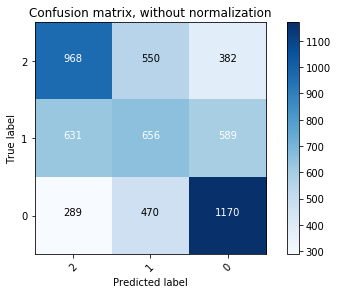

In [34]:
#Plotting Results
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_temp['label'].values, title='Confusion matrix, without normalization')
plt.show()